In [1]:
import os
import numpy as np
import pandas as pd
from dotenv import load_dotenv

load_dotenv()
ambiente_local = os.getenv('AMBIENTE_MAC')
data_path = 'cdi_historico.xlsx'

df = pd.read_excel('cdi_historico.xlsx', engine='openpyxl')
array = df.iloc[:, :2].values
months = [item.month for item in array[:, 0]]
years = [item.year for item in array[:, 0]]
array = np.column_stack((array, months, years))
print(array[0:13,:])
print(type(array))


[[Timestamp('2010-01-01 00:00:00') 0.0862 1 2010]
 [Timestamp('2010-02-01 00:00:00') 0.0862 2 2010]
 [Timestamp('2010-03-01 00:00:00') 0.0861 3 2010]
 [Timestamp('2010-04-01 00:00:00') 0.0938 4 2010]
 [Timestamp('2010-05-01 00:00:00') 0.0937 5 2010]
 [Timestamp('2010-06-01 00:00:00') 0.1012 6 2010]
 [Timestamp('2010-07-01 00:00:00') 0.1063 7 2010]
 [Timestamp('2010-08-01 00:00:00') 0.1063 8 2010]
 [Timestamp('2010-09-01 00:00:00') 0.1061 9 2010]
 [Timestamp('2010-10-01 00:00:00') 0.1064 10 2010]
 [Timestamp('2010-11-01 00:00:00') 0.1064 11 2010]
 [Timestamp('2010-12-01 00:00:00') 0.1065 12 2010]
 [Timestamp('2011-01-01 00:00:00') 0.1114 1 2011]]
<class 'numpy.ndarray'>


In [2]:
from log_data import StockData
from datetime import datetime

## upload data
load_dotenv()
ambiente_local = os.getenv('AMBIENTE_MAC')
data_path = 'acoes_precos2.txt'

file_path = ambiente_local + data_path
stock_data = StockData(file_path)
weekdays = [StockData.date_to_weekday(date) for date in stock_data.dates]

data_datetimes = np.array([datetime.strptime(data, "%Y-%m-%d") for data in stock_data.dates])
meses = np.array([data.month for data in data_datetimes])
anos = np.array([data.year for data in data_datetimes])
data_datetimes = np.column_stack((data_datetimes, meses, anos))

In [14]:
import pandas as pd

# df = pd.read_csv('portfolio_quant.csv', delimiter=',', header=0)
df = pd.read_csv('portfolio_quant.csv', header=None, delimiter=',')

In [16]:
df.tail(10)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
276,2023-1,VALE3,PETR4,BBDC4,ITUB4,MGLU3,BOVA11,BBAS3,ABEV3,B3SA3,...,PETR3,PRIO3,RENT3,BPAC11,GGBR4,LREN3,SUZB3,AMER3,HAPV3,WEGE3
277,2023-2,VALE3,PETR4,ITUB4,BBDC4,BBAS3,BOVA11,B3SA3,MGLU3,ABEV3,...,ELET3,PETR3,BPAC11,RENT3,LREN3,GGBR4,HAPV3,WEGE3,BBSE3,NTCO3
278,2023-3,VALE3,PETR4,ITUB4,BOVA11,B3SA3,BBDC4,PRIO3,ABEV3,BBAS3,...,HAPV3,MGLU3,ELET3,PETR3,LREN3,ASAI3,NTCO3,RRRP3,GGBR4,WEGE3
279,2023-4,VALE3,PETR4,BOVA11,ITUB4,BBDC4,BBAS3,PRIO3,B3SA3,ELET3,...,RENT3,LREN3,ABEV3,MGLU3,BPAC11,NTCO3,SUZB3,RRRP3,WEGE3,HAPV3
280,2023-5,VALE3,PETR4,BOVA11,ITUB4,BBDC4,BBAS3,B3SA3,RENT3,MGLU3,...,LREN3,PETR3,HAPV3,ELET3,ABEV3,SUZB3,SMAL11,GGBR4,BPAC11,VBBR3
281,2023-6,VALE3,PETR4,BOVA11,ITUB4,B3SA3,BBAS3,RENT3,BBDC4,PETR3,...,LREN3,PRIO3,MGLU3,EQTL3,ELET3,HAPV3,SMAL11,RAIL3,BPAC11,ABEV3
282,2023-7,VALE3,PETR4,BOVA11,ITUB4,BBDC4,BBAS3,LREN3,PRIO3,B3SA3,...,PETR3,ABEV3,RENT3,RAIL3,MGLU3,SMAL11,ASAI3,EQTL3,BPAC11,ELET3
283,2023-8,VALE3,PETR4,ITUB4,BOVA11,BBDC4,PETR3,HAPV3,BBAS3,ELET3,...,ABEV3,PRIO3,LREN3,RENT3,RAIL3,SMAL11,BPAC11,MGLU3,GGBR4,ITSA4
284,2023-9,VALE3,PETR4,ITUB4,BOVA11,PETR3,BBDC4,B3SA3,RENT3,BBAS3,...,LREN3,RAIL3,ABEV3,SUZB3,BPAC11,ELET3,SMAL11,WEGE3,EQTL3,HAPV3
285,2023-10,PETR4,VALE3,ITUB4,PETR3,PRIO3,B3SA3,BOVA11,BBAS3,BBDC4,...,SUZB3,SMAL11,HAPV3,ABEV3,RAIL3,WEGE3,LREN3,BPAC11,ELET3,RDOR3


In [33]:
print(df.iloc[285,0])
ano = df.iloc[285,0][:4]
mes = df.iloc[285,0][df.iloc[285,0].find('-') + 1:]
print(int(ano))
print(int(mes))

2023-10
2023
10


In [35]:
valores_unicos = set()

# Iterar sobre as colunas começando da segunda coluna
for coluna in df.columns[1:]:
    valores_unicos_coluna = set(df[coluna].unique())
    valores_unicos.update(valores_unicos_coluna)

# Agora, valores_unicos contém todos os valores únicos nas colunas, excluindo a primeira
print(valores_unicos)

{'BRKM5', 'RRRP3', 'MULT3', 'EMBR3', 'BBSE3', 'GOAU4', 'KEPL3', 'RAIL3', 'CPLE6', 'RADL3', 'BBAS3', 'RAPT4', 'VBBR3', 'FLRY3', 'EQTL3', 'GFSA3', 'IRBR3', 'LREN3', 'ITSA4', 'ASAI3', 'COGN3', 'CIEL3', 'GGBR4', 'UGPA3', 'BPAC11', 'PETR4', 'MRFG3', 'ALPA4', 'CASH3', 'AMER3', 'SUZB3', 'ETER3', 'ITUB4', 'QUAL3', 'HYPE3', 'ELET3', 'CVCB3', 'BRPR3', 'WEGE3', 'GOLL4', 'XPBR31', 'PRIO3', 'FESA4', 'MGLU3', 'PETR3', 'AZUL4', 'CYRE3', 'CPFE3', 'HAPV3', 'ABEV3', 'ELET6', 'B3SA3', 'BBDC3', 'SHUL4', 'BRFS3', 'CSAN3', 'CMIG4', 'RENT3', 'ECOR3', 'SBSP3', 'VALE3', 'KLBN11', 'BRAP4', 'POSI3', 'TUPY3', 'MYPK3', 'SMAL11', 'BOVA11', 'GRND3', 'RDOR3', 'CSNA3', 'USIM5', 'RANI3', 'CRFB3', 'DASA3', 'JBSS3', 'NTCO3', 'SANB11', 'LIGT3', 'VULC3', 'UNIP6', 'ROMI3', 'BBDC4', 'TOTS3', 'CCRO3', 'MRVE3'}


In [55]:
import numpy as np

class StockData:
    def __init__(self, file_path):
        # Ler os dados
        with open(file_path, 'r') as file:
            lines = file.readlines()

        # Processar os dados
        data = [line.strip().split(', ') for line in lines]

        # Obter listas únicas de datas e ativos mantendo a ordem
        self.tickers = []
        self.dates = []
        for item in data:
            ticker, date, _ = item
            if ticker not in self.tickers:
                self.tickers.append(ticker)
            if date not in self.dates:
                self.dates.append(date)

        # Ordenar as datas em ordem crescente
        sorted_dates = sorted(self.dates, key=lambda x: (int(x.split('-')[0]), int(x.split('-')[1]), int(x.split('-')[2])))
        
        # Reordenar os dados com base nas datas ordenadas
        sorted_data = sorted(data, key=lambda x: (int(x[1].split('-')[0]), int(x[1].split('-')[1]), int(x[1].split('-')[2])))

        # Criar matriz de preços
        self.price_matrix = np.zeros((len(sorted_dates), len(self.tickers)))
        
        # Preencher a matriz de preços
        for item in sorted_data:
            ticker, date, price = item
            row_idx = sorted_dates.index(date)
            col_idx = self.tickers.index(ticker)
            self.price_matrix[row_idx][col_idx] = float(price)

        # Atualizar self.dates para refletir a ordem correta
        self.dates = sorted_dates

In [56]:
stock_data = StockData('prices_portfolioquant.txt')

In [58]:
stock_data.dates[-1]

'2023-10-25'

In [59]:
stock_data.tickers

['ASAI3',
 'CVCB3',
 'BBDC3',
 'RDOR3',
 'BRFS3',
 'BRAP4',
 'BPAC11',
 'BRKM5',
 'VBBR3',
 'B3SA3',
 'UNIP6',
 'XPBR31',
 'MRVE3',
 'PETR3',
 'ITUB4',
 'AMER3',
 'ETER3',
 'ELET3',
 'RENT3',
 'HYPE3',
 'PETR4',
 'SMAL11',
 'BRPR3',
 'KLBN11',
 'SUZB3',
 'ABEV3',
 'PRIO3',
 'BOVA11',
 'LREN3',
 'MGLU3',
 'HAPV3',
 'CPLE6',
 'CSAN3',
 'MRFG3',
 'CSNA3',
 'ECOR3',
 'BBDC4',
 'VULC3',
 'QUAL3',
 'GGBR4',
 'GOAU4',
 'SBSP3',
 'GRND3',
 'FLRY3',
 'BBAS3',
 'RANI3',
 'ELET6',
 'MULT3',
 'FESA4',
 'EQTL3',
 'LIGT3',
 'AZUL4',
 'MYPK3',
 'WEGE3',
 'CASH3',
 'USIM5',
 'TUPY3',
 'ALPA4',
 'GOLL4',
 'CPFE3',
 'RAPT4',
 'CCRO3',
 'DASA3',
 'JBSS3',
 'COGN3',
 'VALE3',
 'SHUL4',
 'CIEL3',
 'NTCO3',
 'RAIL3',
 'CRFB3',
 'SANB11',
 'ROMI3',
 'TOTS3',
 'CYRE3',
 'UGPA3',
 'EMBR3',
 'POSI3',
 'RADL3',
 'ITSA4',
 'KEPL3',
 'CMIG4',
 'BBSE3',
 'GFSA3',
 'IRBR3',
 'RRRP3']

11.03

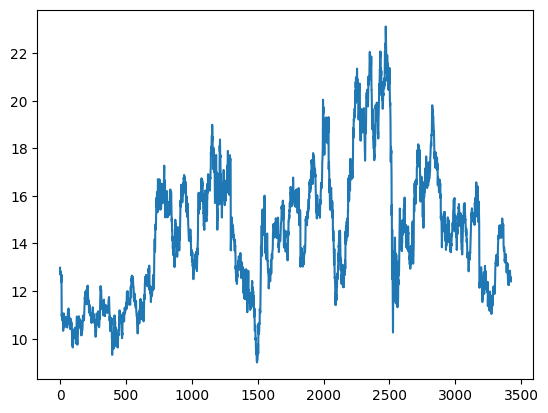